In [154]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 45.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import spacy
nlp = spacy.load('en_core_web_md')

In [4]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
stop=nltk.corpus.stopwords.words('english')

In [5]:
# creat tag map between treebank and wordnet
# tree bank : collection of syntactically annotated sentences
tag_map = {
"CC": None, #formatted. conjunction (and, but, or)
'CD': wn.NOUN, # original number (one,two)
'DT': None, # delimiter (a, the)
'EX': wn.ADV, #and my "there" (there)
"FW": None, # foreign word (mea culpa)
"IN": wn.ADV,# preposition/subjunctive conjunction (of, in,by) 
'JJ': [wn.ADJ, wn.ADJ_SAT],# adjective # (yellow)
'JJR': [wn.ADJ, wn.ADJ_SAT], # add, comparator (larger)
"JJS": [wn.ADJ, wn.ADJ_SAT], # add, superlative (wildest)
"LS": None, #list item tag(1,2,One)
'MD': None, # modal (can, should)
'NN': wn.NOUN, #noun, sing. or nugget (llama)
'NNS': wn.NOUN, #noun, plural (Llamas)
"NNP": wn.NOUN, # proper noun, vocals. (IBM)
'NNPS': wn.NOUN, # proper noun, plural (Carolina)
"PDT": [wn.ADJ, wn.ADJ_SAT], # predeterminer (all, both)
'POS':None, # end of ownership
'PRP': None, # personal pronoun (I, you, he)
'prp$': None, # possessive pronoun (your, one's)
"RB": wn.ADV, #adv (quickly, never)
'RBR': wn.ADV, # adverb, comparative (faster)
'RBS':wn.ADV,# adverb, superlative (fastest)
'RP': [wn.ADJ, wn.ADJ_SAT], # particle (up, off)
'SYM': None, #symbol, # (+, %, &)
'TO': None, # 'to' (to)
'UH': None, # interjection (uh, oops)
'VB': wn.VERB,# verb base form # (eat)
'VBD': wn.VERB, # verb past tense (eat)
'VBG': wn.VERB, #verb gerund (to eat)
'VBN': wn.VERB, # past participle (eaten)
"VBP": wn.VERB, #non-3sg pres verb (eat)
'VBZ': wn.VERB,# verb зsg pres (egts) 
}

In [6]:
lemma=WordNetLemmatizer()
def get_lemma(text):
    l=[]
    tags=pos_tag(text.split())
    for token,tag in tags:
        try:
             l.append(lemma.lemmatize(token,pos=tag_map[tag][0]))
        except:
            continue
    return l

In [14]:
from termcolor import colored
def cleaning(df):
    """
    - remove empty strings
    - remove duplicates
    """
    # remove empty string
    blanks=[]
    for i,v in df.itertuples():
        if pd.isna(v) or (isinstance(v, str) and (v.strip() == "")):
            blanks.append(i)
    if len(blanks)>0:
        df=df.drop(blanks)
        print(f"found {colored(len(blanks),'red')} blanks")
    else:
        print("no blanks found")

    # remove duplicates
    if df.duplicated().sum() !=0:
        print(f"dropped {colored(df.duplicated().sum(),'red')} : values")
        df=df.drop_duplicates()
    else:
        print("no duplicates found")
    return df

In [47]:
import re
import string
def preprocessing(df,col):
    # lowercasing
    df[col]=df[col].apply(lambda x: " ".join(t.lower() for t in x.split()))
    # remove emails
    df[col]=df[col].apply(lambda x: re.sub("\S+\@\S+",'',x))
    # remove URls
    df[col]=df[col].apply(lambda x: re.sub("\S+\.\S+",'',x))
    # remove punctations
    df[col]=df[col].apply(lambda x: re.sub(f'[{re.escape(string.punctuation)}]',' ',x))
    # remove stopwords
    df[col]=df[col].apply(lambda x :" ".join(t for t in x.lower().split() if t not in stop))
    # remove \n or \t
    df[col]=df[col].apply(lambda x: re.sub('\n|\t',' ',x))
    # remove 2 characters words
    df[col]=df[col].apply(lambda x: re.sub(r' \w\w ',' ',x) )
    # remove 1 character words
    df[col]=df[col].apply(lambda x: re.sub(r' \w ',' ',x) )
    # remove extra spaces more than or equals "2" 
    df[col]=df[col].apply(lambda x: re.sub(" {2,}",' ',x))
    # select alphapetical only
    df[col]=df[col].apply(lambda x: re.sub("[^a-z]+",' ',x) )
    # strip string
    df[col]=df[col].apply(lambda x: x.strip())
    # get lemma
    # df[col]=df[col].apply(lambda x: " ".join(get_lemma(x)))
    return df

In [9]:
# remove empty strings  
# remove duplicates 
# remove 1 character words
# remove 2 characters words

In [15]:
data_path=r"/kaggle/input/movie-reviews/reviews.txt"
labels_path=r"/kaggle/input/movie-reviews/labels.txt"
with open(data_path, 'r') as f:
    reviews = f.read()
with open(labels_path, 'r') as f:
    labels = f.read()

In [42]:
y=pd.DataFrame(np.array(labels.split(sep="\n")),columns=['label'])
x=pd.DataFrame(np.array(reviews.split(sep='\n')),columns=['review'])

### first cleaning and removing empty strings & duplicates

In [43]:
x=cleaning(x)

found 1 blanks
dropped 98 : values


In [44]:
y=y.label[x.index]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,stratify=y,shuffle=True,random_state=42)

In [46]:
y_train.value_counts()

label
positive    9976
negative    9945
Name: count, dtype: int64

In [48]:
x_train=pd.DataFrame(X_train,columns=['review'])
x_test=pd.DataFrame(X_test,columns=['review'])

In [49]:
X_train

,review
8519,so american pie beta house is the th america...
11742,pinjar is a genuinely good film with great ac...
12125,i was at this film s premiere at the toronto ...
21792,always enjoy the great acting of drew barrymor...
9984,remember the early days of pay per view i do ...
...,...
24601,it is not often i watch a film that is as drea...
15451,everyone in a while disney makes one of thoes...
19597,normally when i write a review for a movie onl...
10267,just a dumb old movie . first stanwyck s son ...


In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
prep_train=preprocessing(x_train,col='review')
prep_test=preprocessing(x_test,col='review')

In [52]:
from sklearn.preprocessing import LabelEncoder

lb=LabelEncoder()
y_train=lb.fit_transform(y_train)
y_test=lb.transform(y_test)

# Try ML Models

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

In [54]:

clf_nb=Pipeline([ ('tfidf',TfidfVectorizer(ngram_range=(1,1),max_features=10000, stop_words='english')),
                 ('clf',MultinomialNB())
])

clf_svc=Pipeline([ ('tfidf',TfidfVectorizer(ngram_range=(1,1),max_features=10000, stop_words='english')),
                ('clf',LinearSVC())
])

clf_xgb=Pipeline([ ('tfidf',TfidfVectorizer(max_features=10000, stop_words='english')),
                ('clf',XGBClassifier())
])

In [55]:
clf_nb.fit(prep_train['review'], y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, stop_words='english')),
                ('clf', MultinomialNB())])

In [56]:
predictions = clf_nb.predict(prep_test['review'])

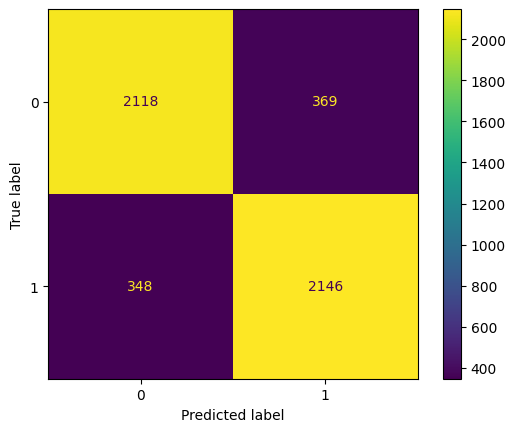

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report
cm=confusion_matrix(y_test,predictions)
ConfusionMatrixDisplay(cm,display_labels=pd.unique(y_test)).plot()

In [58]:
# Print a classification report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      2487
           1       0.85      0.86      0.86      2494

    accuracy                           0.86      4981
   macro avg       0.86      0.86      0.86      4981
weighted avg       0.86      0.86      0.86      4981



In [59]:
clf_svc.fit(prep_train['review'], y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, stop_words='english')),
                ('clf', LinearSVC())])

In [60]:
predictions = clf_svc.predict(prep_test['review'])

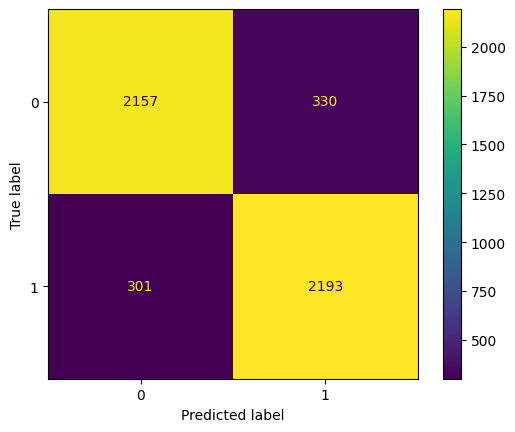

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report
cm=confusion_matrix(y_test,predictions)
ConfusionMatrixDisplay(cm,display_labels=pd.unique(y_test)).plot()

In [62]:
# Print a classification report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      2487
           1       0.87      0.88      0.87      2494

    accuracy                           0.87      4981
   macro avg       0.87      0.87      0.87      4981
weighted avg       0.87      0.87      0.87      4981



In [63]:
clf_xgb.fit(prep_train['review'], y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, stop_words='english')),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [64]:
predictions = clf_xgb.predict(prep_test['review'])

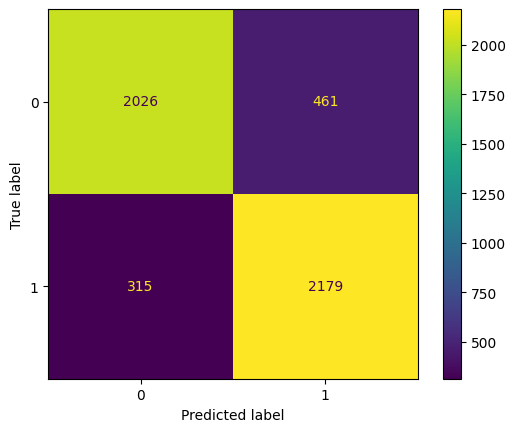

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report
cm=confusion_matrix(y_test,predictions)
ConfusionMatrixDisplay(cm,display_labels=pd.unique(y_test)).plot()

In [66]:
# Print a classification report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      2487
           1       0.83      0.87      0.85      2494

    accuracy                           0.84      4981
   macro avg       0.85      0.84      0.84      4981
weighted avg       0.85      0.84      0.84      4981



# Try VADER

In [194]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [195]:
df=prep_train.copy()

In [198]:
sid=SentimentIntensityAnalyzer()
df['scores']=df['review'].apply(lambda rev: sid.polarity_scores(rev))
df['compound']=df['scores'].apply(lambda s:s['compound'])
df['comp_score']=df['compound'].apply(lambda s:1 if s>=0 else 0)

In [199]:
df.head()

,review,scores,compound,comp_score
8519,american pie beta house american pie movie ser...,"{'neg': 0.12, 'neu': 0.681, 'pos': 0.199, 'com...",0.8621,1
11742,pinjar genuinely good film great acting good n...,"{'neg': 0.053, 'neu': 0.63, 'pos': 0.318, 'com...",0.9810,1
12125,film premiere toronto film festival screening ...,"{'neg': 0.061, 'neu': 0.83, 'pos': 0.11, 'comp...",0.4654,1
21792,always enjoy great acting drew barrymore great...,"{'neg': 0.069, 'neu': 0.681, 'pos': 0.249, 'co...",0.9371,1
9984,remember early days pay per view almost rememb...,"{'neg': 0.056, 'neu': 0.743, 'pos': 0.201, 'co...",0.9303,1


In [200]:
print(classification_report(y_train,df['comp_score']))


              precision    recall  f1-score   support

           0       0.79      0.48      0.60      9945
           1       0.63      0.87      0.73      9976

    accuracy                           0.68     19921
   macro avg       0.71      0.68      0.66     19921
weighted avg       0.71      0.68      0.66     19921



# Try using LSTM

In [67]:
def get_longest_text(texts):
    longest=0
    for text in texts:
        text_len=len(text.split())
        longest=max(text_len,longest)
    return longest

In [68]:
longest_input=get_longest_text(prep_train['review'])
longest_input

1400

In [74]:
# here we put 200 instead of 1387 due to low memory

In [72]:
# import re
# text = ' '.join(x['review'])
# words = re.findall(r'\b\w+\b', text.lower())
# unique_words = set(words)
# vocab_size = len(unique_words)
# vocab_size

74072

In [102]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer=Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(prep_train['review'])

sequences=tokenizer.texts_to_sequences(prep_train['review'])
pad_sequences_train=pad_sequences(sequences,padding='post',maxlen=500)

In [103]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

67085

In [104]:
pad_sequences_train.shape

(19921, 500)

In [105]:
pad_sequences_train

array([[  178,  3033,  9619, ...,     0,     0,     0],
       [11253,  1840,     7, ...,     0,     0,     0],
       [    4,  4777,  5398, ...,     0,     0,     0],
       ...,
       [ 1604,   744,   610, ...,     0,     0,     0],
       [  829,    59,     3, ...,     0,     0,     0],
       [ 1462,  4680,  7276, ...,     0,     0,     0]], dtype=int32)

In [106]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing import sequence

In [141]:
model=Sequential([

    layers.Embedding(input_dim=vocab_size,output_dim=100),
    layers.Bidirectional(layers.LSTM(128,return_sequences=True)),    
    layers.Bidirectional(layers.LSTM(64,return_sequences=True)),    
    layers.Bidirectional(layers.LSTM(32)),    
    # layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')

])

In [142]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(pad_sequences_train,y_train,validation_split=0.2,epochs=10,batch_size=64)

Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 51s 180ms/step - accuracy: 0.6185 - loss: 0.6359 - val_accuracy: 0.6045 - val_loss: 0.6474
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 44s 178ms/step - accuracy: 0.6570 - loss: 0.6177 - val_accuracy: 0.6871 - val_loss: 0.6188
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 44s 177ms/step - accuracy: 0.7880 - loss: 0.4827 - val_accuracy: 0.8507 - val_loss: 0.3774
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 44s 178ms/step - accuracy: 0.9319 - loss: 0.1943 - val_accuracy: 0.8575 - val_loss: 0.3758
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 44s 177ms/step - accuracy: 0.9609 - loss: 0.1244 - val_accuracy: 0.8477 - val_loss: 0.4318
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 44s 178ms/step - accuracy: 0.9836 - loss: 0.0598 - val_accuracy: 0.8678 - val_loss: 0.4699
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 44s 177ms/step - accuracy: 0.9934 - loss: 0.0299 - val_accuracy: 0.8482 - val_loss: 0.6143
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 44s 178ms/step - accuracy: 0.9964 - loss: 0

# Try using GloVe

In [155]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
hits = 0
misses = 0

In [156]:
print("Creating embedding matrix...")
# Iterate through YOUR tokenizer's vocabulary
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        # SpaCy handles the lookup internally
        token = nlp(word)
        
        # Check if the word has a vector (is not a rare OOV word)
        if token.has_vector:
            embedding_matrix[i] = token.vector
            hits += 1
        else:
            misses += 1

print(f"Converted {hits} words. Missed {misses} words.")

Creating embedding matrix...
Converted 55237 words. Missed 11847 words.


In [160]:
from tensorflow.keras import regularizers
model2=Sequential([

    layers.Embedding(input_dim=vocab_size,output_dim=300,weights=[embedding_matrix],trainable=False),
    layers.Bidirectional(layers.LSTM(128,return_sequences=False, recurrent_dropout=0.3)),    
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')

])

In [161]:
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.fit(pad_sequences_train,y_train,validation_split=0.2,epochs=10,batch_size=64)

Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.6524 - loss: 0.6157 - val_accuracy: 0.7420 - val_loss: 0.5695
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.6074 - loss: 0.6684 - val_accuracy: 0.6984 - val_loss: 0.5774
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.7606 - loss: 0.5181 - val_accuracy: 0.7905 - val_loss: 0.4635
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.8042 - loss: 0.4449 - val_accuracy: 0.7892 - val_loss: 0.4489
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.8199 - loss: 0.4108 - val_accuracy: 0.8003 - val_loss: 0.4292
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.8241 - loss: 0.3928 - val_accuracy: 0.8080 - val_loss: 0.4225
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.8447 - loss: 0.3570 - val_accuracy: 0.8025 - val_loss: 0.4138
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.8441 - loss: 0.3609 - 

# Try Bert

In [169]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

In [170]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [175]:
print("Tokenizing data... (this may take a moment)")
train_encodings = tokenizer(list(X_train['review']), truncation=True, padding=True, )
test_encodings = tokenizer(list(X_test['review']), truncation=True, padding=True)

Tokenizing data... (this may take a moment)


In [187]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(1000).batch(16) # BERT uses smaller batch sizes usually

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(16)

In [188]:
len(pd.unique(y_train))

2

In [189]:
model = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', 
    num_labels=2
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [192]:
from transformers import create_optimizer
import tensorflow as tf

# 1. Calculate Training Steps
# BERT needs to know how long it will train to adjust the learning rate
batch_size = 16
num_epochs = 3
batches_per_epoch = len(train_dataset) 
total_train_steps = int(batches_per_epoch * num_epochs)

# 2. Create the Optimizer using Hugging Face's tool
# This creates a version-compatible optimizer automatically
optimizer, schedule = create_optimizer(
    init_lr=3e-5,                # The ideal learning rate for BERT
    num_warmup_steps=0,          # Optional: Warmup steps
    num_train_steps=total_train_steps
)

# 3. Compile
# We do not pass a loss function here because HuggingFace models 
# calculate loss internally if you don't specify it.
model.compile(optimizer=optimizer, metrics=['accuracy'])

In [193]:
# 4. Train
print("Starting BERT training...")
history = model.fit(
    train_dataset, 
    validation_data=test_dataset, 
    epochs=num_epochs
)

Starting BERT training...
Epoch 1/3
1246/1246 [==============================] - 736s 576ms/step - loss: 0.1793 - accuracy: 0.9315 - val_loss: 0.2267 - val_accuracy: 0.9113
Epoch 2/3
1246/1246 [==============================] - 716s 575ms/step - loss: 0.0782 - accuracy: 0.9744 - val_loss: 0.2389 - val_accuracy: 0.9199
Epoch 3/3
1246/1246 [==============================] - 716s 574ms/step - loss: 0.0289 - accuracy: 0.9924 - val_loss: 0.2938 - val_accuracy: 0.9227


## Got 92% on bert with just 3 epochs

In [247]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_59 (Dropout)        multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
